# Pengu Pairs

Logical steps in a pairs trading process:<br><br>

1. Find cointegrated time-series within the ASX 300 (by using the Engle-Granger Test: Looks for unit roots in the residuals of a linear regression) <br> <br> *P.S. Must decide whether you want to do this for log prices or regular prices*

2. Using the pairs that are classified as cointegrated, map a linear combination/relationship to find the 'coefficient' for the pair - To understand what the 'hedge ratio' is

3. If they come out having p-value less than 0.01 or 0.05 in a cointegration test, validate it by using the 'check_station' function - dicky fuller test to test stationarity

4. **Repeat steps 1 --> 4 for: <br><br> a) different intervals (minutes, 10 minutes, 15 minutes, 30 minutes, 45 minutes, 60 minutes, 2 hours?, daily, weekly etc.) <br><br>and,<br><br> b) For different time periods e.g. 2010-2011, 2015-2016 ....**

In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge

import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import holoviews as hv
from bokeh.palettes import Spectral8


https://blog.quantinsti.com/pairs-trading-basics/
https://blog.quantinsti.com/selection-pairs-statistical-arbitrage-project-divyant-agarwal/

https://www.quantconnect.com/learning/articles/investment-strategy-library/optimal-pairs-trading

https://www.quantconnect.com/learning/articles/investment-strategy-library/intraday-dynamic-pairs-trading-using-correlation-and-cointegration-approach

## Statistical Arb, Pairs Trading, Mean-Reversion:

##### In order to understand pairs trading, we need to understand three mathematical concepts:
Stationarity, 
Integration, and 
Cointegration

<span style="color:blue"> *The input to this function "data" is simply a dataframe full of securities which you would like the test the "pair" effectiveness for. It outputs a matrix of p-values, the scores and then finally those that are deemed pairs* </span>

Import data and extract tickers:

In [2]:
asx = pd.read_csv('asx_200MC.csv')
master_df = asx.dropna()
top_150 = master_df.iloc[:149,:]
master_df.head()

ASX code                     Company name Listing date  \
0      BHP                BHP GROUP LIMITED   1885-08-13   
1      CBA  COMMONWEALTH BANK OF AUSTRALIA.      12/9/91   
2      CSL                      CSL LIMITED       8/6/94   
3      NAB  NATIONAL AUSTRALIA BANK LIMITED      31/1/62   
4      WBC      WESTPAC BANKING CORPORATION      18/7/70   

                              GICs industry group    Market Cap  
0                                       Materials  2.220860e+11  
1                                           Banks  1.640130e+11  
2  Pharmaceuticals, Biotechnology & Life Sciences  1.386810e+11  
3                                           Banks  8.803954e+10  
4                                           Banks  7.519952e+10

In [3]:
#only need tickers
tickers = master_df['ASX code'].to_list()
tickers = tickers[0:150]

Extract data from yahoo fin:

In [4]:
df = yf.download(tickers, start = '2010-01-31')

[*********************100%***********************]  150 of 150 completed

29 Failed downloads:
- BRG: No timezone found, symbol may be delisted
- AFI: No timezone found, symbol may be delisted
- GQG: Period 'max' is invalid, must be one of ['1d', '5d']
- STO: No data found for this date range, symbol may be delisted
- TLC: No timezone found, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- SQ2: No timezone found, symbol may be delisted
- BKW: No data found for this date range, symbol may be delisted
- SGM: No data found for this date range, symbol may be delisted
- SSR: No data found for this date range, symbol may be delisted
- CHC: No data found for this date range, symbol may be delisted
- ARG: No data found for this date range, symbol may be delisted
- S32: No timezone found, symbol may be delisted
- NWSLV: No timezone found, symbol may be delisted
- JBH: Period 'max' is invalid, must be one of ['1d', '5d']
- A2M: No timezone found, symbol m

Show data:

In [5]:
prices = df['Adj Close'].dropna(axis = 1)
#prices = np.log(prices)
prices.tail(1)

AGG        AIA         ALL     ALX    AMP  \
Date                                                                         
2023-03-31 00:00:00-04:00  99.639999  61.889999  110.809998  193.75  306.5   

                                 APA   ASX        AUB        BEN    BHP  ...  \
Date                                                                     ...   
2023-03-31 00:00:00-04:00  36.060001  7.97  35.049999  26.940001  63.41  ...   

                             NWL        ORA        ORI        PRU        RIO  \
Date                                                                           
2023-03-31 00:00:00-04:00  12.44  84.769997  24.969999  82.739998  68.599998   

                                  RMD   SOL        VEA    WDS        WOR  
Date                                                                      
2023-03-31 00:00:00-04:00  218.990005  4.45  45.169998  22.43  64.650002  

[1 rows x 33 columns]

#### Function allows us to extract a matrix of the 'scores' of the cointegration, the p-values and the actual pairs as tuples

In [6]:
def find_cointegrated_pairs1(data):
    n = data.shape[1]
    keys = data.keys()
    pairs = []
    pvalues = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            pvalue = result[1]

            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
                pvalues.append(pvalue)

    pairs_pvalues_df = pd.DataFrame({'Pairs': pairs, 'PValues': pvalues})
    return pairs_pvalues_df

### These pairs are really well tested on a daily basis. Since 2010, they have been cointegrated with a confidence of 99%. This is 252 x 13 years almost of data that validates this

In [7]:
pairs = find_cointegrated_pairs1(prices)
pairs = pairs.sort_values(by ='PValues')

<AxesSubplot:title={'center':'P-Values for the Pairs that have been detected based on a threshold'}, xlabel='Pairs'>

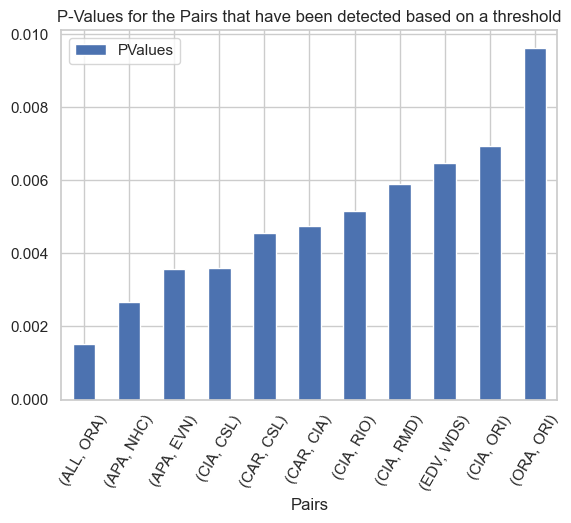

In [8]:
pairs.plot.bar(x = 'Pairs', y = 'PValues', rot = 60, title = 'P-Values for the Pairs that have been detected based on a threshold')

- The possible number of pairs given "n" number of assets is equal to the combination formula: <br><br> C(n,k) = n! / (k! * (n-k)!)<br><br> - Where k is number of stocks in each pair (2 for us)

In [9]:
n = len(prices.columns)
k = 2

def combination(n,k):
    comb = math.factorial(n)/(math.factorial(k) * math.factorial(n-k))
    return comb

print(f'The maximum possible pairs from a list of {n} stocks is {combination(n,k)}')

The maximum possible pairs from a list of 33 stocks is 528.0


### Let's see which sectors our pairs are in, are they the same?:

In [10]:
# For the purpose of loc's below:
master_df = master_df.set_index('ASX code')

In [11]:
def get_gics_sector(pair_dict, index): # The index is just to provide which pair i want the sector for
    stock_ticker = list(pair_dict)[index] #takes a list of the Pairs and maps it to it's GICS sector in the next line
    return master_df.loc[stock_ticker, 'GICs industry group']

pairs['Industry 1'] = pairs['Pairs'].map(lambda x: get_gics_sector(x, 0))
pairs['Industry 2'] = pairs['Pairs'].map(lambda x: get_gics_sector(x, 1))

pairs

Pairs   PValues                              Industry 1  \
0   (ALL, ORA)  0.001510                       Consumer Services   
2   (APA, NHC)  0.002679                               Utilities   
1   (APA, EVN)  0.003573                               Utilities   
5   (CIA, CSL)  0.003610                               Materials   
4   (CAR, CSL)  0.004557                   Media & Entertainment   
3   (CAR, CIA)  0.004756                   Media & Entertainment   
7   (CIA, RIO)  0.005147                               Materials   
8   (CIA, RMD)  0.005913                               Materials   
9   (EDV, WDS)  0.006488  Consumer Staples Distribution & Retail   
6   (CIA, ORI)  0.006929                               Materials   
10  (ORA, ORI)  0.009637                               Materials   

                                        Industry 2  
0                                        Materials  
2                                           Energy  
1                                        Materials  
5   Pharmaceuticals, Biotechnology & Life Sciences  
4   Pharmaceuticals, Biotechnology & Life Sciences  
3                                        Materials  
7                                        Materials  
8                 Health Care Equipment & Services  
9                                           Energy  
6                                        Materials  
10                                       Materials

* #### As seen above, the most cointegrated stocks aren't neccessarily in the exact same sector! 

#### Make a df with prices only associated with the paurs:

In [12]:
#Get a list of all the tickers we care about (i.e., those in our pairs DataFrame)
tickers_to_keep = set(pair[0] for pair in pairs['Pairs']) | set(pair[1] for pair in pairs['Pairs'])

# Only keep columns with relevant tickers and create new DataFrame
relevant_prices_df = prices.loc[:, prices.columns.isin(tickers_to_keep)]
relevant_prices_df.columns

Index(['ALL', 'APA', 'CAR', 'CIA', 'CSL', 'EDV', 'EVN', 'NHC', 'ORA', 'ORI',
       'RIO', 'RMD', 'WDS'],
      dtype='object')

# <font color='green'> Visualising the Pairs Prices </font>

## Price plots since 2010:

In [13]:
# Index from 1
ret_2010 = relevant_prices_df.pct_change()
#Changing data to all start from 1
cum_prod_2010 = (1+ret_2010).cumprod()

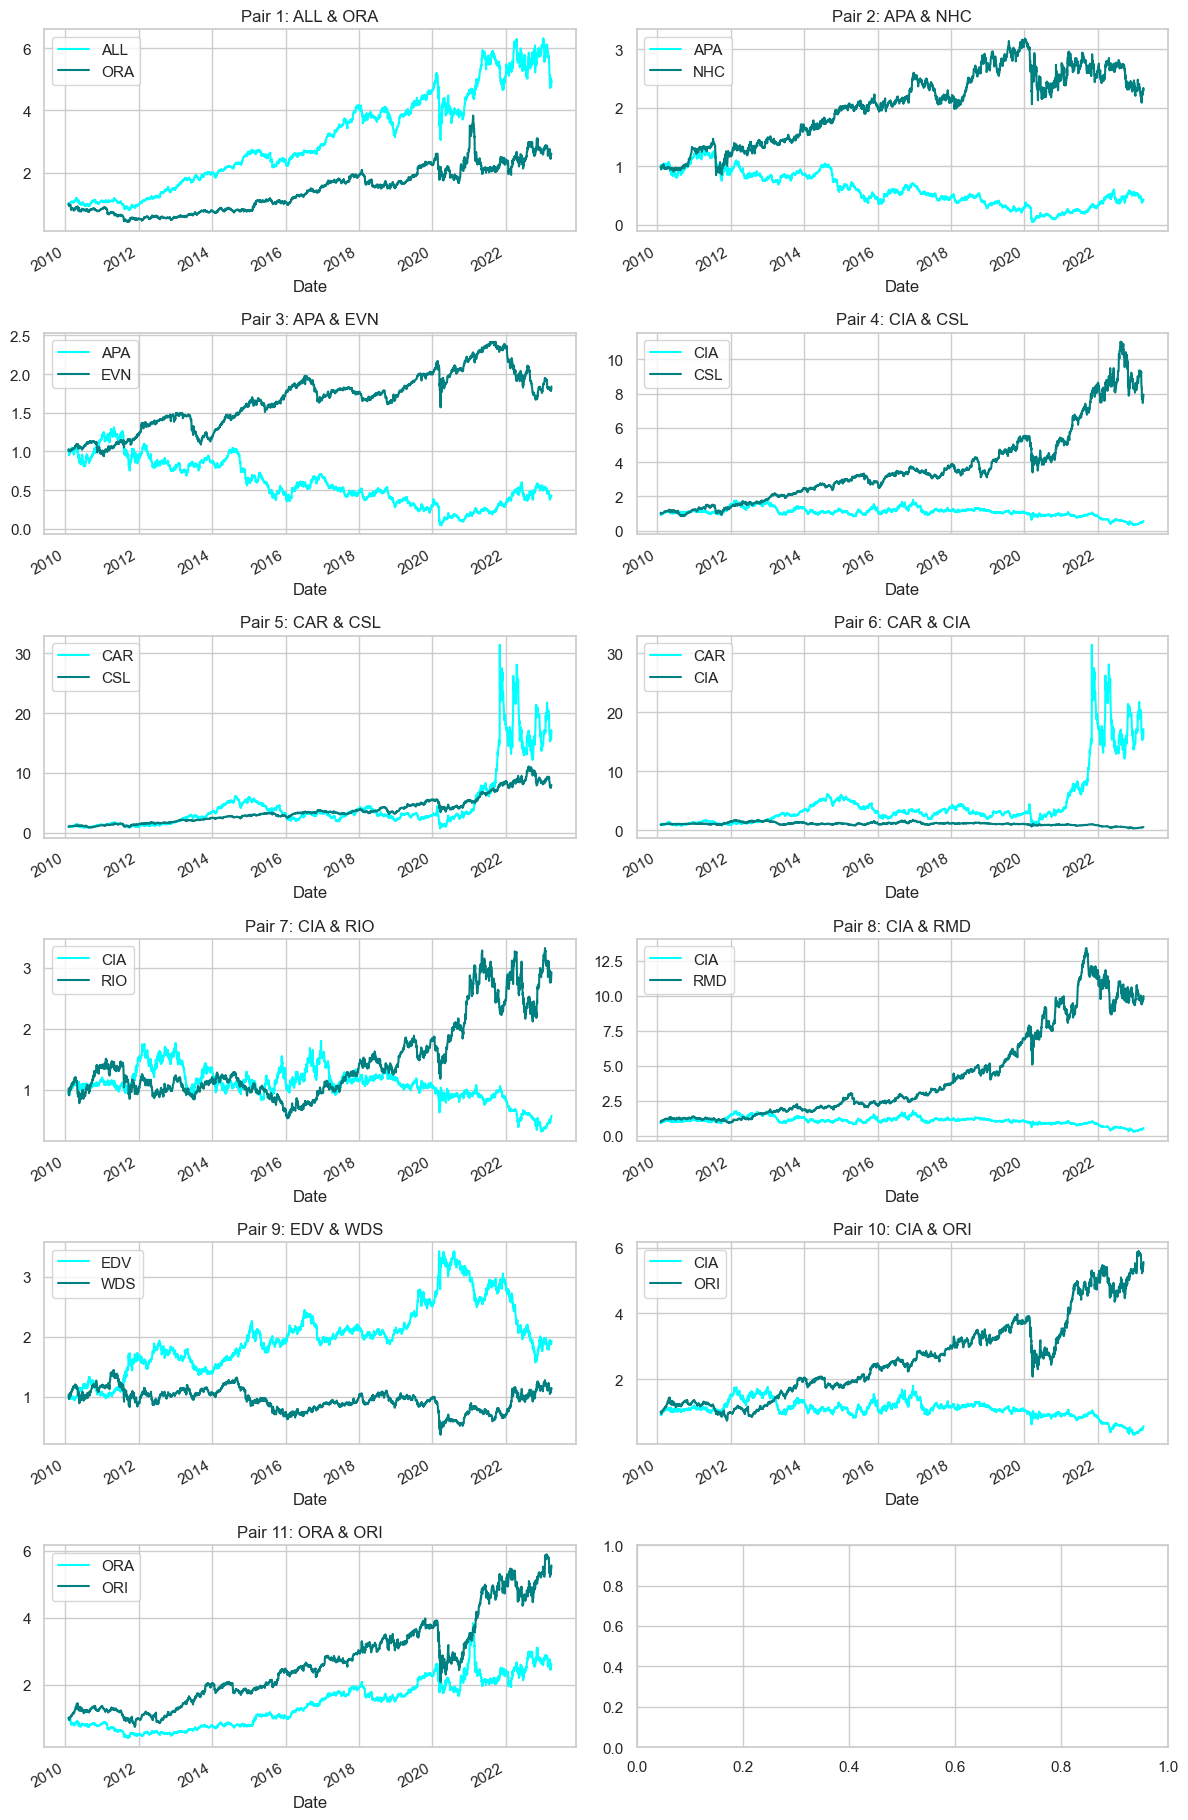

In [14]:
num_pairs = len(pairs['Pairs'])
num_rows = math.ceil(num_pairs / 2)

# Create unique plot for each pair
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 1.67*len(pairs['Pairs'])))
for i, pair in enumerate(pairs['Pairs']):
    tickers = list(pair)
    plot_df = cum_prod_2010.loc[:, tickers]
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index][col_index]
    plot_df.plot(ax=ax, title=f"Pair {i+1}: {tickers[0]} & {tickers[1]}", color=['aqua', 'teal'])
plt.tight_layout()

## Since 2022

In [15]:
# Clean data for 2022 to now
relevant_prices_df1 = relevant_prices_df.iloc[-310:,:]
ret_2022 = relevant_prices_df1.pct_change()
#Changing data to all start from 1
cum_prod_2022 = (1+ret_2022).cumprod()

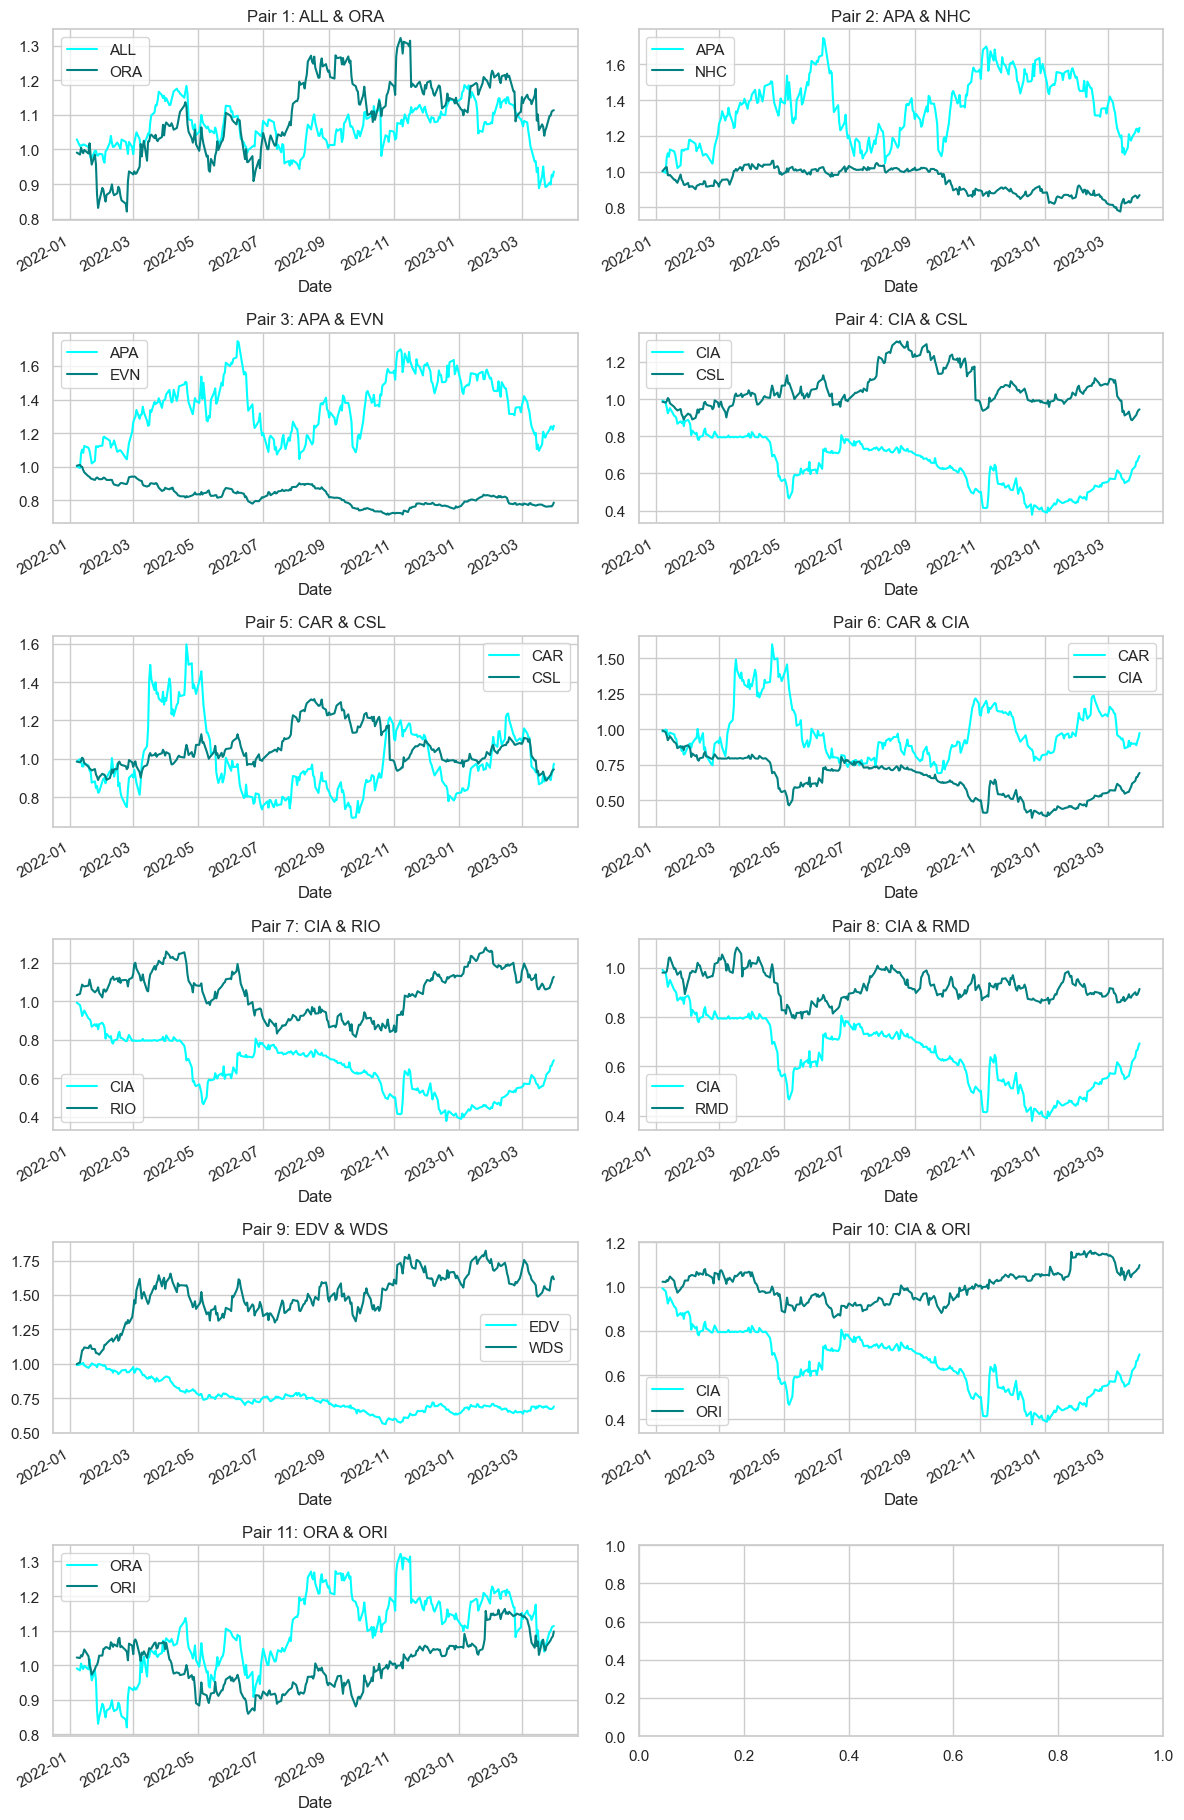

In [16]:
num_pairs = len(pairs['Pairs'])
num_rows = math.ceil(num_pairs / 2)

# Create unique plot for each pair
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 1.67*len(pairs['Pairs'])))
for i, pair in enumerate(pairs['Pairs']):
    tickers = list(pair)
    plot_df = cum_prod_2022.loc[:, tickers]
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index][col_index]
    plot_df.plot(ax=ax, title=f"Pair {i+1}: {tickers[0]} & {tickers[1]}", color=['aqua', 'teal'])
plt.tight_layout()

# <font color='green'> Hedge Ratio / Linear Combination + Spread</font>

In [17]:
# Only keep columns with relevant tickers and create new DataFrame
display(relevant_prices_df)
display(pairs['Pairs'])

ALL        APA         CAR   CIA  \
Date                                                                 
2010-02-01 00:00:00-05:00   22.252216  83.869484   11.370000  6.48   
2010-02-02 00:00:00-05:00   22.675720  85.695953   11.430000  6.28   
2010-02-03 00:00:00-05:00   22.163063  84.623016   11.240000  6.11   
2010-02-04 00:00:00-05:00   21.316072  80.986488   10.490000  5.90   
2010-02-05 00:00:00-05:00   21.479521  80.593330   10.560000  6.04   
...                               ...        ...         ...   ...   
2023-03-27 00:00:00-04:00  106.989998  35.380001  179.809998  3.41   
2023-03-28 00:00:00-04:00  106.339996  35.900002  177.580002  3.55   
2023-03-29 00:00:00-04:00  109.699997  35.910000  183.669998  3.56   
2023-03-30 00:00:00-04:00  109.089996  35.380001  187.759995  3.65   
2023-03-31 00:00:00-04:00  110.809998  36.060001  194.800003  3.71   

                                  CSL        EDV        EVN        NHC  \
Date                                                                     
2010-02-01 00:00:00-05:00   28.455292  46.955799   5.506193  24.866028   
2010-02-02 00:00:00-05:00   28.597414  47.067139   5.569905  24.697100   
2010-02-03 00:00:00-05:00   29.826225  46.229259   5.674568  24.203840   
2010-02-04 00:00:00-05:00   29.784430  47.330799   5.642717  24.061947   
2010-02-05 00:00:00-05:00   28.630836  47.447979   5.592655  24.149778   
...                               ...        ...        ...        ...   
2023-03-27 00:00:00-04:00  217.429993  88.150002   9.840000  57.890285   
2023-03-28 00:00:00-04:00  218.990005  88.300003   9.850000  57.632862   
2023-03-29 00:00:00-04:00  222.750000  88.139999   9.840000  56.920002   
2023-03-30 00:00:00-04:00  225.020004  88.610001   9.950000  57.439999   
2023-03-31 00:00:00-04:00  226.070007  90.540001  10.130000  58.070000   

                                 ORA        ORI        RIO         RMD  \
Date                                                                     
2010-02-01 00:00:00-05:00  32.406017   4.491925  23.405910   21.947079   
2010-02-02 00:00:00-05:00  32.387794   4.579673  23.890745   22.262623   
2010-02-03 00:00:00-05:00  32.487984   4.496103  23.252985   22.241301   
2010-02-04 00:00:00-05:00  30.657290   4.391639  21.855106   21.716822   
2010-02-05 00:00:00-05:00  30.976076   4.362389  22.123575   23.409649   
...                              ...        ...        ...         ...   
2023-03-27 00:00:00-04:00  83.529999  24.290001  65.089996  215.820007   
2023-03-28 00:00:00-04:00  83.610001  24.400000  66.059998  213.089996   
2023-03-29 00:00:00-04:00  84.470001  24.559999  66.830002  213.520004   
2023-03-30 00:00:00-04:00  84.690002  24.639999  68.110001  215.949997   
2023-03-31 00:00:00-04:00  84.769997  24.969999  68.599998  218.990005   

                                 WDS  
Date                                  
2010-02-01 00:00:00-05:00  19.869225  
2010-02-02 00:00:00-05:00  20.469244  
2010-02-03 00:00:00-05:00  20.328959  
2010-02-04 00:00:00-05:00  19.248978  
2010-02-05 00:00:00-05:00  19.005451  
...                              ...  
2023-03-27 00:00:00-04:00  21.290001  
2023-03-28 00:00:00-04:00  22.110001  
2023-03-29 00:00:00-04:00  22.629999  
2023-03-30 00:00:00-04:00  22.730000  
2023-03-31 00:00:00-04:00  22.430000  

[3315 rows x 13 columns]

0     (ALL, ORA)
2     (APA, NHC)
1     (APA, EVN)
5     (CIA, CSL)
4     (CAR, CSL)
3     (CAR, CIA)
7     (CIA, RIO)
8     (CIA, RMD)
9     (EDV, WDS)
6     (CIA, ORI)
10    (ORA, ORI)
Name: Pairs, dtype: object

## Calc the Rolling 30 day beta coefficients:

When running the back-test algorithm, we can choose to either use a static long-term beta (which is the hedge ratio, how much you're short/longing 1 stock compared to the other), OR, use a more time-varying beta (rolling):

In [18]:
rolling_betas = []

# Iterate through rows of df2 and extract ticker pairs
for i, row in pairs.iterrows():
    
    # Extract ticker symbols
    ticker_1, ticker_2 = row['Pairs']
    
    # Select columns from relevant_prices_df using ticker symbols and create new dataframe with only two columns
    prices_df = relevant_prices_df[[ticker_1, ticker_2]]
    
    # Apply rolling window to new dataframe with a size of 30 days (30 rows)
    window_size = 30
    rolling_prices_df = prices_df.rolling(window=window_size)


    # Perform linear regression and extract beta parameter for each window
    rolling_betas_pair = []
    lr = LinearRegression()
    for j, window in enumerate(rolling_prices_df):
        if j >= window_size - 1:
            x = window[ticker_1].values.reshape(-1, 1)
            y = window[ticker_2].values.reshape(-1, 1)
            
            lr.fit(x,y)
            beta_val = lr.coef_[0]
            
            # Store beta value a dictionary
            rolling_betas_dict = {'Pair': row['Pairs'], 'Beta_Value': beta_val}
             
             # Append the dictionary to the list of betas 
            rolling_betas_pair.append(rolling_betas_dict)


    rolling_betas.extend(rolling_betas_pair)
    # Create pandas DataFrame from list of betas
    named_betas = pd.DataFrame(rolling_betas)

### Clean the Beta's from "long" data to usable data using this loop:

In [19]:
# Use groupby() to group the beta values by Pair
grouped_betas = named_betas.groupby(['Pair'])
wide_betas = pd.DataFrame(index = relevant_prices_df.iloc[window_size-1:,:].index) # Window size -1 to get the lag on the rolling_window
# Iterate through groups and add a new column for each pair of ticker symbols with corresponding beta values
for name, group in grouped_betas:
    col_name = name
    wide_betas[col_name] = list(group['Beta_Value'])

    wide_betas = wide_betas.apply(lambda x: x.astype(float))

#Print Beta's
wide_betas.head(5)

(ALL, ORA)  (APA, EVN)  (APA, NHC)  (CAR, CIA)  \
Date                                                                        
2010-03-15 00:00:00-04:00   -1.545323    0.010117    0.064684   -0.122711   
2010-03-16 00:00:00-04:00   -1.506611    0.009890    0.062599   -0.131426   
2010-03-17 00:00:00-04:00   -1.487928    0.010787    0.057397   -0.140592   
2010-03-18 00:00:00-04:00   -1.425574    0.010824    0.057180   -0.128583   
2010-03-19 00:00:00-04:00   -1.499322    0.011371    0.054715   -0.163338   

                           (CAR, CSL)  (CIA, CSL)  (CIA, ORI)  (CIA, RIO)  \
Date                                                                        
2010-03-15 00:00:00-04:00   -0.185198    1.931992    0.607138    2.952568   
2010-03-16 00:00:00-04:00   -0.212890    2.080443    0.620955    2.992320   
2010-03-17 00:00:00-04:00   -0.265432    2.192128    0.646793    3.090162   
2010-03-18 00:00:00-04:00   -0.225072    2.393165    0.673710    3.163774   
2010-03-19 00:00:00-04:00   -0.265212    2.712941    0.707855    3.078580   

                           (CIA, RMD)  (EDV, WDS)  (ORA, ORI)  
Date                                                           
2010-03-15 00:00:00-04:00    2.656594   -0.620159   -0.088314  
2010-03-16 00:00:00-04:00    2.692533   -0.549695   -0.094909  
2010-03-17 00:00:00-04:00    2.679217   -0.486919   -0.105105  
2010-03-18 00:00:00-04:00    2.658533   -0.450164   -0.115713  
2010-03-19 00:00:00-04:00    2.523352   -0.282220   -0.117468

### Add to existing DF:

In [20]:
#find average "30 day" beta
mean_beta = wide_betas.mean()

# Add to pairs DF
pairs['Average Hedge Ratio'] = pairs['Pairs'].map(mean_beta) # SYNTAX IS: New column = OG_DF[index of whatever e.g. Tickers].map(Dictionary or wherever the data you want is)
pairs

Pairs   PValues                              Industry 1  \
0   (ALL, ORA)  0.001510                       Consumer Services   
2   (APA, NHC)  0.002679                               Utilities   
1   (APA, EVN)  0.003573                               Utilities   
5   (CIA, CSL)  0.003610                               Materials   
4   (CAR, CSL)  0.004557                   Media & Entertainment   
3   (CAR, CIA)  0.004756                   Media & Entertainment   
7   (CIA, RIO)  0.005147                               Materials   
8   (CIA, RMD)  0.005913                               Materials   
9   (EDV, WDS)  0.006488  Consumer Staples Distribution & Retail   
6   (CIA, ORI)  0.006929                               Materials   
10  (ORA, ORI)  0.009637                               Materials   

                                        Industry 2  Average Hedge Ratio  
0                                        Materials             0.255953  
2                                           Energy             0.143665  
1                                        Materials            -0.001496  
5   Pharmaceuticals, Biotechnology & Life Sciences             2.512135  
4   Pharmaceuticals, Biotechnology & Life Sciences             0.614140  
3                                        Materials             0.041809  
7                                        Materials             0.845495  
8                 Health Care Equipment & Services             1.277551  
9                                           Energy            -0.064137  
6                                        Materials             0.333393  
10                                       Materials             0.073165

In [21]:
# regression_prices = relevant_prices_df.iloc[29:,:]
# regression_prices.index = pd.to_datetime(regression_prices.index)
# regression_prices

Spread = SP_1 - (beta * SP_2)

In [22]:
# spreads = {}

# for pair in pairs['Pairs']:
#     stock1, stock2 = pair
    
#     # Get price data for both stocks
#     prices1 = regression_prices[stock1]
#     prices2 = regression_prices[stock2]
    
#     # Get rolling beta coefficients for this pair
#     # betas = wide_betas.loc[pair]
    
# #     # Calculate spread using equation from prompt
# #     spread = prices1 - (betas * prices2)
    
# #     # Add calculated series to dictionary of spreads
# #     spreads[pair] = spread

# # # Create DataFrame from dictionary of spreads 
# # df_spread_pairs = pd.DataFrame(spreads)

Below, "normalized_S1" is the scaled (hedge ratio'd) component of the spread calculation:

In [53]:
start_time = '2010-03-15 00:00:00-04:00'
end_time = '2020-02-15 00:00:00-04:00'

# Set our relevant pair
S1 = relevant_prices_df["APA"].loc[start_time:end_time]
S2 = relevant_prices_df["NHC"].loc[start_time:end_time]

best_pair_beta = wide_betas.iloc[:,0] # select only first
beta = best_pair_beta.loc[:end_time]
normalized_S1 = beta * S1

In [54]:
#############Establish plot for Spread#############
# Spread scaled by the beta
spread = S2 - normalized_S1 # "ratio"

#calc 1STD of spread
std = spread.std()

#Create DF to plot
plotter = pd.DataFrame(spread, columns = ['spread'])
plotter['mean'] = spread.mean()
plotter['+1 STD'] = plotter['mean'] + std
plotter['-1 STD'] = plotter['mean'] - std
plotter['+mid STD'] = plotter['mean'] + (std * 0.5)
plotter['-mid STD'] = plotter['mean'] - (std * 0.5)

# Combine the original line plot and shaded regions into a single plot
plot = plotter.hvplot.line(line_color = ['#6baed6', '#000000', '#000000', '#000000', '#DD4968', '#DD4968'] , line_dash=['solid', 'solid','dashed','dashed', 'dashed', 'dashed'])

# Set plot options
plot.opts(title='Spread: Scaled by the coefficient', width=900, height=550)


#############Establish plot for prices#############
plot_prices = prices[[S1.name, S2.name]]
plot_prices.index = prices.index

##OUTPUT##
print(f'Beta or "hedge ratio" is {round(beta.iloc[-1],3)}. This essentially means, you need to buy/sell {S1.name} by {round(beta.iloc[-1],3)} compared to {S2.name} when trading.')

display(plot)

display(plot_prices.hvplot(line_color=['blue', 'red'], rot = 70, width = 800, height = 400, title = 'Price Movement', shared_axes = False, xlabel = ''))

Beta or "hedge ratio" is 0.926. This essentially means, you need to buy/sell APA by 0.926 compared to NHC when trading.


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### Testing for Stationarity:

In [55]:
def check_station(X, cutoff = 0.01):
    #Hypothesis_0 in adfuller is unit root exists (non-stationary) ///////  unit root = non-stationary
    #Must observe significant p-va;ue to convince ourselves series is stationary

    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print (f'p-value = {pvalue}, therefore likely stationary')
        return True
    else:
        print (f'p-value = {pvalue}, therefore likely not stationary')
        return False

Check for our data:

In [56]:
round(check_station(spread), 5)

p-value = 1.5228365595044624e-05, therefore likely stationary


1

# <br><br> Backtesting the pairs:

<font color='green'> Let's try and intuitively understand the spread (thats been adjusted for the hedge-ratio). If the spread goes super high above the mean, given spread = S1 - (beta * S2), S1 would be going much higher than statistically expected compared to S2. If the spread goes super below the mean, S2 is rising much more than S1. <br> <br> Option (1): Spread goes high, we Short S1 and Long S2. <br><br> Option (2): Spread goes low, we Long S1 and Short 2.</font> <br><br><br> **The Pseudo code for this process should be:** <br><br> *If spread => +1 STD, sell df['S1'] and buy df['S2'] until spread = mean, then close position and buy df['S1] and sell df['S2'].<br><br>elif spread <= -1 STD, buy df['S1'] and sell df['S2'] until spread = mean, then close position and sell df['S1] and buy df['S2'].*

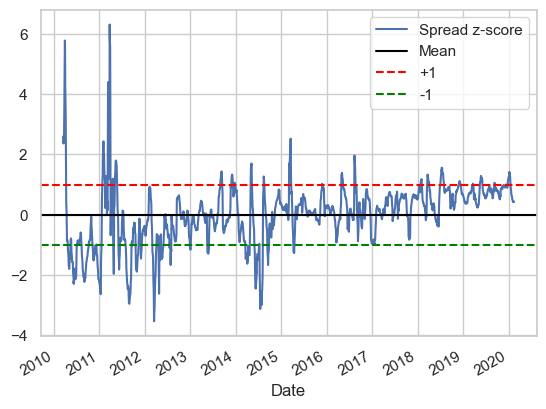

In [57]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [58]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), spread], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

In [59]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().hvplot(title = f'Backtest of {S1.name} & {S2.name}', rot = 90)

:Curve   [Date]   (0)

Take Beta's needed:

In [171]:
beta_values = wide_betas[('ALL', 'ORA')]

In [219]:
plot_prices.index = pd.to_datetime(plot_prices.index)

In [241]:
# trading_df = pd.concat([beta_values, plot_prices.loc[start_time:end_time]], axis = 1, join = 'inner')
# trading_df1 = pd.concat([trading_df, plotter], axis = 1)